In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import IGM

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

k = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log

z = 2
z2 = (1 + z) / 3

In [2]:
with open('rate.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

In [3]:
t_arr = [1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12, 5e12, 1e13]
t_num = len(t_arr)

In [4]:
def get_nij(i, j, t): # nij = dN / (dV dgammae_j dOmegae_i)
    gamma6 = gamma_e_arr[j] / 1e6
    Gamma_IC = 1.1e-12 * z2**4 * gamma6
    
    gamma_max = 1 / (Gamma_IC * (1 / Gamma_IC / gamma_e_arr[j] - t))
    if gamma_max < 0:
        gamma_max = float('inf')
    
    
    nij = 0
    for jp in range(j, 399):
        if gamma_e_arr[jp] <= gamma_max:
            sum_ij = (gamma_e_arr[jp] - gamma_e_arr[jp-1]) * rate_trans[i][jp]
            if gamma_e_arr[jp+1] > gamma_max:
                fraction = (gamma_max - gamma_e_arr[jp]) / (gamma_e_arr[jp+1] - gamma_e_arr[jp])
                sum_ij = sum_ij * fraction
                #print(f't={t:.1e}, fraction={fraction}')
            nij += sum_ij
    nij = nij / (Gamma_IC * gamma_e_arr[j]**2)
    return nij

In [5]:
def get_ni(i, nij): # integrate gamma_e (1/gamma_e) nij
    ni = 0
    for j in range(1, 400):
        sum_i = (gamma_e_arr[j] - gamma_e_arr[j-1]) / gamma_e_arr[j] * nij[i][j]
        ni += sum_i
    return ni

In [6]:
def get_Px(ni, Omega_x):
    Px = np.zeros((400, 1))
    for i in range(400): # Omega_x
        for j in range(1, 400): # theta
            if theta_e_arr[j-1] > Omega_x[i]:
                sum_ij = ni[j-1] * (np.sqrt(theta_e_arr[j]**2 - Omega_x[i]**2) - np.sqrt(theta_e_arr[j-1]**2 - Omega_x[i]**2))
                Px[i] += sum_ij
    return Px

In [7]:
Omega_x = np.logspace(-8,0, 400).reshape(400, 1)

In [8]:
nij = np.zeros((t_num, 400, 400)) # t theta[i] gamma[j]
for k in range(t_num):
    for i in range(400):
        for j in range(1, 400):
            nij[k][i][j-1] = get_nij(i, j, t_arr[k])

In [9]:
ni = np.zeros((t_num, 400)) # about theta
for k in range(t_num):
    for i in range(400):
        ni[k][i] = get_ni(i, nij[k])

In [10]:
Px = np.zeros((t_num, 400)) # # cm^-3 rad^-1
for k in range(t_num):
    Px[k] = get_Px(ni[k], Omega_x).reshape(1, 400)

In [11]:
print(Px[2][0]/Px[0][0]) # t = 1e9 compare to t = 1e8
print(Px[4][0]/Px[2][0]) # t = 1e10 compare to t = 1e9
print(Px[6][0]/Px[4][0]) # t = 1e11 compare to t = 1e10
print(Px[8][0]/Px[6][0]) # t = 1e12 compare to t = 1e11

30.146695286560078
30.667361511468187
34.057405289380384
30.811558996267316


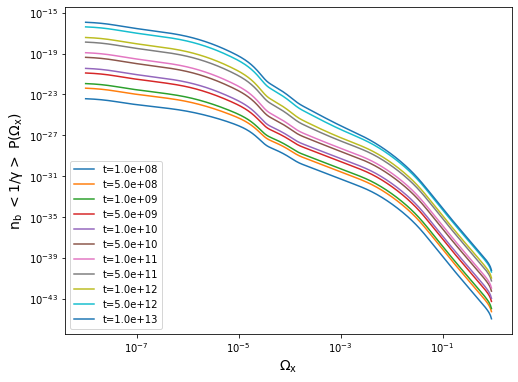

In [12]:
fig = plt.figure(figsize=(8, 6))
for k in range(t_num):
    plt.plot(Omega_x[:-2], Px[k, :-2], label=f't={t_arr[k]:.1e}')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=10)
plt.xlabel('$\mathrm{\Omega_x}$', fontsize = 14)
plt.ylabel('$\mathrm{n_b\ <1/\gamma>\ P(\Omega_x)}$', fontsize = 14)
plt.show()

In [13]:
slop = np.zeros((t_num, 399))
Omega_x = Omega_x.reshape(400, 1)
for k in range(t_num):
    Pxk = Px[k].reshape(400, 1)
    slopk = (Pxk[1:] - Pxk[:-1]) / (Omega_x[1:] - Omega_x[:-1])
    slop[k] = slopk.reshape(1, 399)
    idx_max = np.where(abs(slopk) == max(abs(slopk)))
    print(f't = {t_arr[k]:.1e}, Omega_x = {Omega_x[idx_max]}, slop = {slopk[idx_max]}')

t = 1.0e+08, Omega_x = [1.31916996e-08], slop = [-7.86674616e-17]
t = 5.0e+08, Omega_x = [1.31916996e-08], slop = [-8.57654543e-16]
t = 1.0e+09, Omega_x = [1.31916996e-08], slop = [-2.42335948e-15]
t = 5.0e+09, Omega_x = [1.31916996e-08], slop = [-2.64243644e-14]
t = 1.0e+10, Omega_x = [1.31916996e-08], slop = [-7.46662324e-14]
t = 5.0e+10, Omega_x = [1.31916996e-08], slop = [-9.03276681e-13]
t = 1.0e+11, Omega_x = [1.31916996e-08], slop = [-2.5523992e-12]
t = 5.0e+11, Omega_x = [1.31916996e-08], slop = [-2.78318822e-11]
t = 1.0e+12, Omega_x = [1.31916996e-08], slop = [-7.86448695e-11]
t = 5.0e+12, Omega_x = [1.31916996e-08], slop = [-8.57559734e-10]
t = 1.0e+13, Omega_x = [1.31916996e-08], slop = [-2.42321641e-09]


In [14]:
# at mean density, overdensity = 1
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He
n_e = n_H + 2 * n_He
    
omega_p = (4 * np.pi * r0 * n_e)**0.5 * c

In [15]:
def growth(theta, slop):
    return np.pi * omega_p / 2 / n_e * np.cos(theta)**2 * slop

In [16]:
theta = (theta_e_arr[1:] + theta_e_arr[:-1]) / 2
w = np.zeros((t_num, 399))
for k in range(t_num):
    for i in range(399):
        w[k][i] = growth(theta[i], slop[k][i])

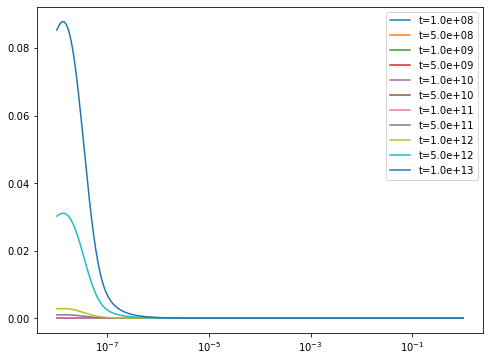

In [17]:
fig = plt.figure(figsize=(8, 6))
for k in range(t_num):
    plt.plot(theta, -w[k], label=f't={t_arr[k]:.1e}')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [18]:
for k in range(t_num):
    wk = w[k]
    idx_max = np.where(abs(wk) == max(abs(wk)))
    print(f't = {t_arr[k]:.1e}, theta = {theta[idx_max]}, w = {wk[idx_max]}')

t = 1.0e+08, theta = [1.35033496e-08], w = [-2.85147317e-09]
t = 5.0e+08, theta = [1.35033496e-08], w = [-3.10875535e-08]
t = 1.0e+09, theta = [1.35033496e-08], w = [-8.78399328e-08]
t = 5.0e+09, theta = [1.35033496e-08], w = [-9.57808535e-07]
t = 1.0e+10, theta = [1.35033496e-08], w = [-2.70643992e-06]
t = 5.0e+10, theta = [1.35033496e-08], w = [-3.27412271e-05]
t = 1.0e+11, theta = [1.35033496e-08], w = [-9.25172579e-05]
t = 5.0e+11, theta = [1.35033496e-08], w = [-0.00100883]
t = 1.0e+12, theta = [1.35033496e-08], w = [-0.00285065]
t = 5.0e+12, theta = [1.35033496e-08], w = [-0.03108412]
t = 1.0e+13, theta = [1.35033496e-08], w = [-0.08783475]


In [19]:
def approx_max(T_b, gamma_b):
    co1 = np.sqrt(np.pi / 8 / e)
    print(co1)
    mu = E_e / k / T_b # T_b: the comoving temperature of the beam in K
    
    return co1 * omega_p * n_b / n_e * mu * gamma_b

In [20]:
erg_to_K = 7.242971666663e+15
T_arr = np.logspace(8, 14, 400) * eV_to_erg * erg_to_K

w_max = approx_max(T_arr[0], gamma_e_arr[0])
    
print(w_max)

0.3800867252665734
8.224388132838017e-16
